In [2]:
#object to store the train data, test data
class data:
    def __init__(self,data_num, x, y, label):
        #data size
        self.data_num = data_num
        #image embedding
        self.x = x
        #label embedding
        self.y = y
        #label
        self.label = label
    #function to get batch from data object
    def get_batch(self, batch_size):    
        have_taken = []
        x_return = []
        y_return = []
        label_return = []
        for i in range(batch_size):
            num = random.randrange(self.data_num)
            while(num in have_taken):
                num = random.randrange(self.data_num)
            have_taken.append(num)
            x_return.append(self.x[num])
            y_return.append(self.y[num])
            label_return.append(self.label[num])
        return data(batch_size, x_return, y_return, label_return)

In [3]:
import numpy as np
import tensorflow as tf
import random
from sklearn import preprocessing
import matplotlib.pyplot as plt

#load lable
(noUse, label_train), (noUse, label_test) = tf.keras.datasets.cifar100.load_data(label_mode='fine')
label_train = label_train.astype(np.int32)
label_test = label_test.astype(np.int32)

#load image embedding 
x_train = np.load('y_embedding4096_train_acc_67.npy')
x_train = np.reshape(x_train,(50000,8*8*64))
x_test = np.load('y_embedding4096_test_acc_67_.npy')
x_test = np.reshape(x_test,(10000,8*8*64))

#load label embedding 
label_embedding = np.load('zero_shot_label_embedding_100_1100.npy')
label_embedding = np.reshape(label_embedding,(110,1000))[10:]
label_embedding = label_embedding.astype(np.float32)

#set every label embedding 
y_train = np.zeros((50000,1000))
for i in range(50000):
    y_train[i] = label_embedding[label_train[i]]
y_test = np.zeros((10000,1000))
for i in range(10000):
    y_test[i] = label_embedding[label_test[i]]

#put data into data object
train_data = data(50000,x_train,y_train,label_train)
test_data  = data(10000,x_test,y_test,label_test)

In [4]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

reset_graph()

In [5]:
#image embedding
xs = tf.placeholder(tf.float32, [None, 8*8*64],name = 'xs')
#label
ys = tf.placeholder(tf.int32, [None, 1],name = 'ys')
#each lable embedding
yss = tf.placeholder(tf.float32, [None, 1000],name = 'yss')
#dropout rate
keep_prob = tf.placeholder(tf.float32)


#network structure
layer1 = tf.layers.dense(xs, 1000, activation = None, name = 'layer1')
layer1_drop = tf.nn.dropout(layer1, keep_prob=keep_prob)
Output = tf.nn.l2_normalize(layer1_drop,1,name = 'Output')

#DeVISE loss function
tLabelMV = tf.diag_part(tf.tensordot(yss,Output, axes=[[1],[1]]),name = 'tLabelMV')
tMV = tf.matmul(label_embedding, tf.transpose(Output), name = 'tMV')
margin = 0.1
loss = tf.reduce_mean(tf.reduce_sum(tf.nn.relu(margin-tLabelMV+tMV),0)-margin,0, name = 'loss')

#calculate accuracy
pre = tf.argmax(tMV, 0)
predict_label = tf.reshape(pre,[-1,1])
acc,acc_op = tf.metrics.accuracy(labels = ys,predictions = predict_label, weights=None,
                                 metrics_collections=None, updates_collections=None, name=None)

#optimizer 
train_step1 =tf.train.AdamOptimizer(0.1).minimize(loss, name = 'training_op')
train_step2 =tf.train.AdamOptimizer(0.01).minimize(loss)

#tensorflow vaiabel initialize
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
tf.local_variables_initializer().run()

#list to store training process
train_loss_record = []
test_loss_record = []
train_acc_record = []
test_acc_record = []

#train 
for i in range(60000):
    #get batch from train data 
    temp = train_data.get_batch(128)
    #train
    sess.run(train_step1, feed_dict={xs:temp.x, ys:temp.label, yss:temp.y, keep_prob:0.3})
      
    if i%1000 ==0  :
        print(i)
        aa = sess.run(loss, feed_dict={xs:temp.x, ys:temp.label, yss:temp.y, keep_prob:1})
        train_loss_record.append(aa)
        print('train loss',aa)
        aa = sess.run(acc_op, feed_dict={xs:temp.x, ys:temp.label, yss:temp.y, keep_prob:1})
        train_acc_record.append(aa)
        print('train accuracy',aa)
        temp = test_data
        aa = sess.run(loss, feed_dict={xs:temp.x, ys:temp.label, yss:temp.y, keep_prob:1})
        test_loss_record.append(aa)
        print('test loss',aa)
        aa = sess.run(acc_op, feed_dict={xs:temp.x, ys:temp.label, yss:temp.y, keep_prob:1})
        test_acc_record.append(aa)
        print('test accuracy',aa)
        print('')
      

0
train loss 0.278133
train accuracy 0.742188
test loss 8.60202
test accuracy 0.0694115

100
train loss 0.913536
train accuracy 0.074493
test loss 1.41641
test accuracy 0.233807

200
train loss 0.315576
train accuracy 0.236558
test loss 0.867578
test accuracy 0.329713

300
train loss 0.240886
train accuracy 0.331345
test loss 0.737282
test accuracy 0.388428

400
train loss 0.214554
train accuracy 0.38937
test loss 0.677728
test accuracy 0.429167

500
train loss 0.108029
train accuracy 0.430173
test loss 0.646794
test accuracy 0.459798



In [22]:
tf.train.Saver().save(sess, "ms2\cifar100_devise") #store checkpoint for zero shot learning

'ms2\\cifar100_devise'

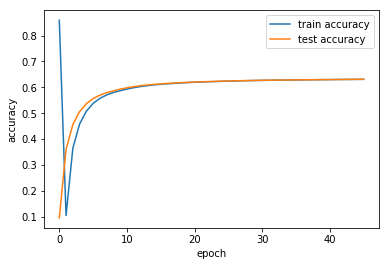

In [15]:
#plot accuracy
plt.plot(train_acc_record,label='train accuracy')
plt.plot(test_acc_record,label='test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('acc.png')
plt.show()

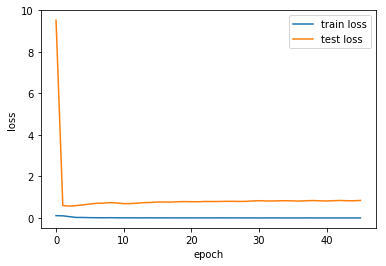

In [16]:
#plot loss
plt.plot(train_loss_record,label='train loss')
plt.plot(test_loss_record,label='test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

In [7]:
from IPython.display import clear_output, Image, display, HTML
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = graph_def
    #strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
    
with tf.Session() as sess:
    show_graph(tf.get_default_graph().as_graph_def())